# ML в Биологии
## Random Forest. Part II.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import seaborn as sns
import scipy.stats
from tqdm import tqdm_notebook
from sklearn import datasets
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter("ignore", DeprecationWarning)

sns.set(context='poster')
%matplotlib inline

### Задача 2

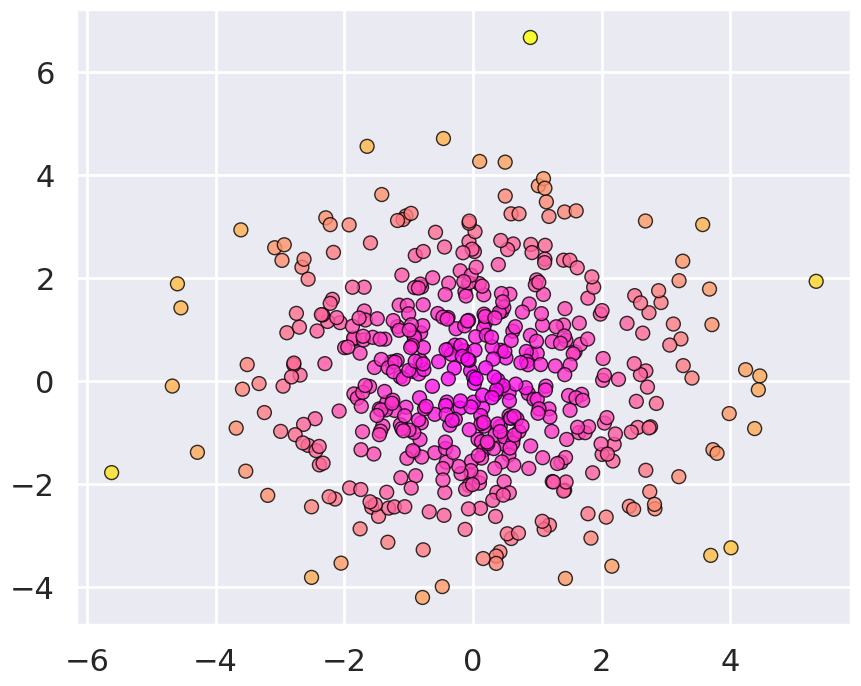

In [3]:
np.random.seed(42)
X_train = scipy.stats.multivariate_normal.rvs(
    size=500, mean=[0, 0], cov=[[3, 0], [0, 3]]
)
y_train = (X_train[:, 0] ** 2 + X_train[:, 1] ** 2) ** 0.5

plt.figure(figsize=(10, 8))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='spring',
            s=100, alpha=0.8, linewidths=1, edgecolors='black')
plt.show()

### Зависимость  качества предсказаний леса от `n_estimators`

Создадим тестовую выборку

In [4]:
np.random.seed(42)
X_test = scipy.stats.multivariate_normal.rvs(
    size=1000, mean=[0, 0], cov=[[3, 0], [0, 3]]
)
y_test = (X_test[:, 0] ** 2 + X_test[:, 1] ** 2) ** 0.5

In [5]:
def cum_metric(model, metric, x_test, y_test):
    '''
    Считает значение метрики в зависимости от количества деревьев в модели

    Мы не обучаем много лесов с разным кол-вом деревьев,
    а смотрим на один обученный лес. Предсказание леса из k деревьев —
    усредненное предсказание первых k деревьев из нашего леса.

    Параметры.
    1) model — модель случайного леса,
    2) metric — вычисляемая метрика,
    3) x_test — данные тестовой выборки,
    4) y_test — метки тестовой выборки.
    '''

    predictions_by_estimators = [est.predict(x_test) for est in model.estimators_] # предсказания конкретных деревьев
    cumpred = np.array(predictions_by_estimators).cumsum(axis=0) \
              / (np.arange(len(predictions_by_estimators)) + 1)[:, np.newaxis] # усреднение первых k моделей для k от 1 до n_estimators
    cumacc = [metric(y_test, pred) for pred in cumpred] # значения метрики качества для k деревьев
    return np.array(cumacc)

Визуализируем значение метрики MSE в зависимости от количества деревьев в модели.
Поскольку каждая модель является случайной, **проведем обучение 1000 раз** и усредним значения метрики.
На графике также нарисуем полупрозрачными кривыми зависимость MSE от количества деревьев для каждой модели.

  0%|          | 0/1000 [00:00<?, ?it/s]

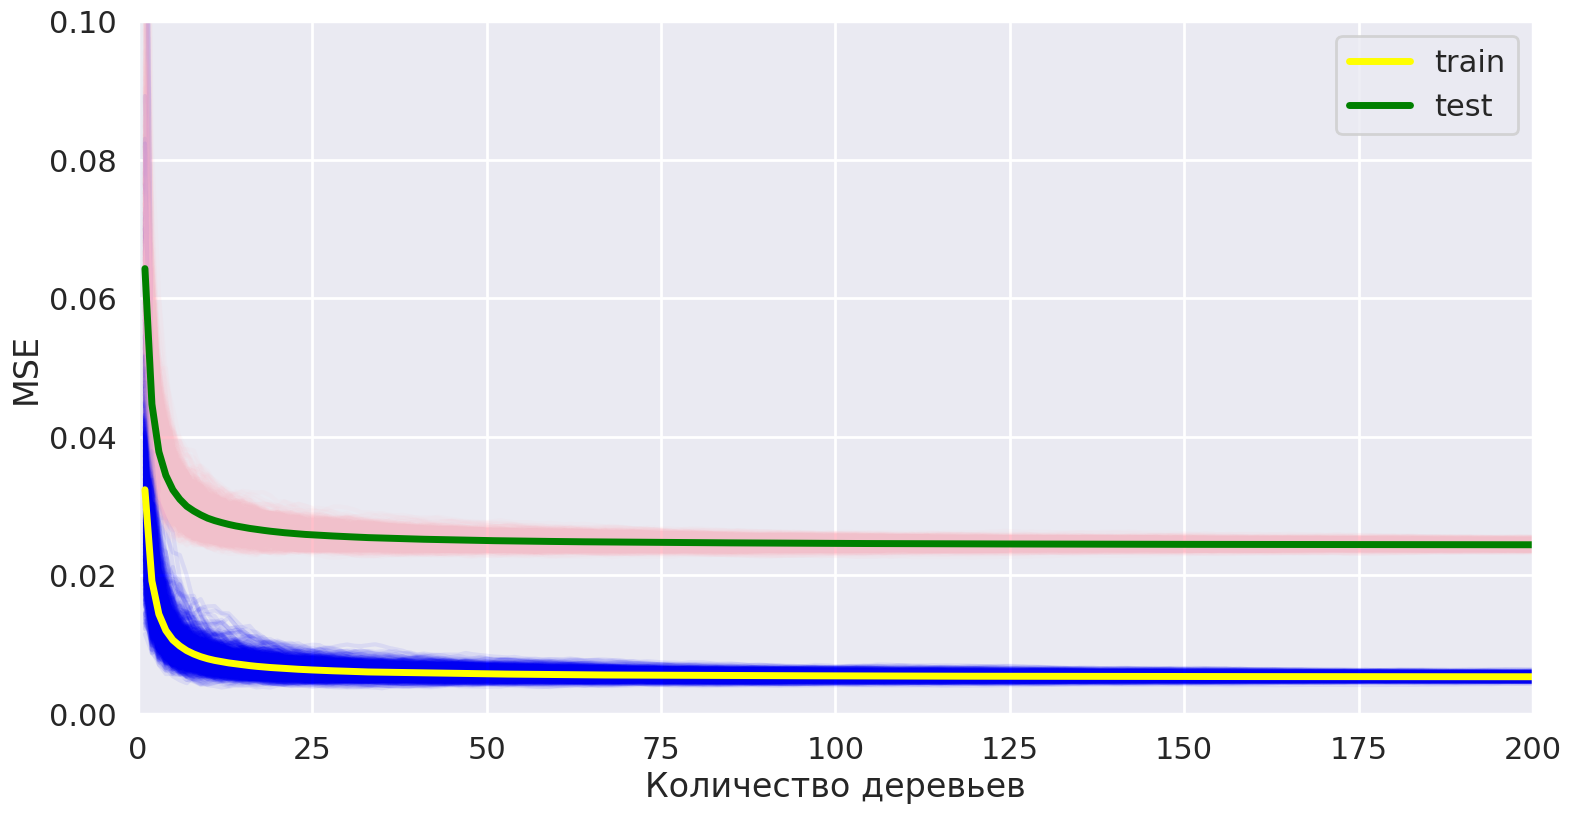

CPU times: user 15min 54s, sys: 22.4 s, total: 16min 17s
Wall time: 13min 22s


In [7]:
%%time

n_iterations = 1000
n_estimators = 200
scores_train = np.zeros((n_iterations, n_estimators))
scores_test = np.zeros((n_iterations, n_estimators))
estrimator_range = np.arange(n_estimators) + 1

plt.figure(figsize=(18, 9))

for i in tqdm_notebook(range(n_iterations), leave=False):
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1)
    rf.fit(X_train, y_train)
    scores_train[i] = cum_metric(rf, MSE, X_train, y_train)
    scores_test[i] = cum_metric(rf, MSE, X_test, y_test)
    plt.plot(estrimator_range, scores_train[i], color='blue', alpha=0.07)
    plt.plot(estrimator_range, scores_test[i], color='pink', alpha=0.07)

plt.plot(estrimator_range, scores_train.mean(axis=0),
         lw=5, color='yellow', label='train')
plt.plot(estrimator_range, scores_test.mean(axis=0),
         lw=5, color='green', label='test')
plt.xlabel('Количество деревьев'), plt.ylabel('MSE')
plt.xlim((0, 200)), plt.ylim((0, 0.1))
plt.legend()
plt.show()

Как ведет себя ошибка с увеличением количества деревьев? Есть ли переобучение? Как это связано с пройденной теорией?

**Ответ:**

Когда количество деревьев невелико, модель при каждом перезапуске ведёт себя по-разному (высокий разброс). По мере увеличения количества деревьев разброс уменьшается, что подтверждается тем, что результаты MSE при перезапусках становятся примерно одинаковыми.

Это соответствует изученной теории: разброс должен уменьшаться приблизительно в T раз, где T — количество деревьев в лесу.

### Зависимость  качества предсказаний леса от значений гиперпараметров

Теперь исследуем зависимость качества предсказаний случайного леса от значений гиперпараметров. Рассмотрим датасет `diabetes` из `sklearn`. В нём исследуется численная оценка прогрессирования диабета у пациентов на основе таких признаков, как возраст, пол, масса тела, среднее кровяное давление и некоторых других. Для того, чтобы лучше понять, что из себя представляют признаки в этом датасете, можно обратиться к этой странице: https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html.

In [8]:
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

In [9]:
print('data shape:', X.shape)
print('target shape:', y.shape)

data shape: (442, 10)
target shape: (442,)


Как и в предыдущих экспериментах, разобьём данные на обучение и тест.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42
)

Подберём оптимальные параметры для `RandomForestRegressor` по сетке.

In [11]:
estimator = RandomForestRegressor(random_state=42)

param_grid = {
      'max_depth': [3, 5, None],
      'n_estimators': [5, 10, 25, 50],
      'min_samples_leaf': [1, 2, 5],
      'min_samples_split': [2, 5]
  }

tree_gridsearch = GridSearchCV(estimator, param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

In [12]:
tree_gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5, None],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 5],
                         'n_estimators': [5, 10, 25, 50]},
             scoring='neg_mean_squared_error')

Выведите лучшие параметры.

In [13]:
print(tree_gridsearch.best_params_)

{'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}


Посчитаем значение метрики `r2-score` для лучшей модели.

In [14]:
print('train r2_score {:.4f}'.format(
    r2_score(tree_gridsearch.best_estimator_.predict(X_train), y_train)
))
print('test r2_score {:.4f}'.format(
    r2_score(tree_gridsearch.best_estimator_.predict(X_test), y_test)
))

train r2_score 0.3933
test r2_score -0.0652


Теперь попробуем резко увеличить значение `min_samples_leaf`. Проведите аналогичный эксперимент.

In [15]:
rf = RandomForestRegressor(random_state=42,
                    max_depth=5, min_samples_leaf=50, min_samples_split=2, n_estimators=50)
rf.fit(X_train, y_train)

print('train r2_score {:.4f}'.format(
    r2_score(rf.predict(X_train), y_train)
))
print('test r2_score {:.4f}'.format(
    r2_score(rf.predict(X_test), y_test)
))

train r2_score -0.9801
test r2_score -0.6907


**Вывод:**

Действительно, метрика стала хуже по сравнению с оптимальным результатом.

Теперь попробуем, наоборот, сделать значение `min_samples_leaf` меньше оптимального.

In [16]:
rf = RandomForestRegressor(random_state=42,
                    max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50)
rf.fit(X_train, y_train)

print('train r2_score {:.4f}'.format(
    r2_score(rf.predict(X_train), y_train)
))
print('test r2_score {:.4f}'.format(
    r2_score(rf.predict(X_test), y_test)
))

train r2_score 0.4924
test r2_score -0.0942


**Вывод:**

Метрика ухудшилась, но не так значительно, как при увеличении параметра. Это логично: повышение минимального значения накладывает дополнительные ограничения, что может всё испортить, тогда как уменьшение даёт больше свободы выбора, но модель всё ещё способна найти оптимальное значение во время обучения.

К тому же, от значения 5 вниз особо сильно не отойдёшь.

Главный вывод — grid search работает!
